<a href="https://colab.research.google.com/github/Eddietrantkt/CF_Quan22280073_Tuong22280102/blob/main/FINANCE_week4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance pandas matplotlib mplfinance prophet scikit-learn

# Import Python Libraries and set defalut value

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [3]:
start_time = "2021-01-01"
end_time = datetime.now()
ngan_hang_vn = ["VCB.VN", "TCB.VN", "ACB.VN", "MBB.VN", "BID.VN", "CTG.VN", "HDB.VN", "TPB.VN", "MSB.VN", "SHB.VN"]

# Download price-volume data

In [4]:
data = yf.download(ngan_hang_vn, start=start_time, end=end_time, auto_adjust=False)
data.tail(3)

[*********************100%***********************]  10 of 10 completed


Price      Adj Close                                                        \
Ticker        ACB.VN   BID.VN   CTG.VN   HDB.VN   MBB.VN   MSB.VN   SHB.VN   
Date                                                                         
2025-11-11   24850.0  38000.0  48500.0  29600.0  23200.0  12100.0  15800.0   
2025-11-12   25200.0  38250.0  49200.0  30000.0  23700.0  12200.0  16300.0   
2025-11-13   25100.0  38300.0  48850.0  29950.0  23500.0  12100.0  16350.0   

Price                                  ...   Volume                      \
Ticker       TCB.VN   TPB.VN   VCB.VN  ...   ACB.VN   BID.VN     CTG.VN   
Date                                   ...                                
2025-11-11  33650.0  16900.0  58900.0  ...  7868106  2395129  8879696.0   
2025-11-12  35000.0  17300.0  59500.0  ...  7135256  2032983  6732674.0   
2025-11-13  35100.0  16950.0  59800.0  ...  5904781  1944401  5672727.0   

Price                                                                      \
Ticker        HDB.VN    MBB.VN   MSB.VN      SHB.VN      TCB.VN    TPB.VN   
Date                                                                        
2025-11-11  16090720  15240350  5453595  70353550.0  11457130.0   4340377   
2025-11-12  18588390  17656290  4379133  91832270.0  13033510.0  10843580   
2025-11-13  12084470  19659540  4513299  65475640.0  12761540.0   4904235   

Price                
Ticker       VCB.VN  
Date                 
2025-11-11  2586585  
2025-11-12  2222657  
2025-11-13  2658685  

[3 rows x 60 columns]

# Convert to DataFrame

In [5]:
# Giả sử DataFrame ban đầu của bạn có tên là 'data'

# 1. Stack cấp độ 'Ticker' (level 1) từ cột xuống thành index
data_stacked = data.stack(level='Ticker')

# 2. Chuyển tất cả các cấp index (Date và Ticker) thành các cột
data_long = data_stacked.reset_index()

# 3. --- ĐÂY LÀ DÒNG BẠN CẦN ---
# Xóa tên 'Price' (tên của trục cột)
data_long = data_long.rename_axis(None, axis=1)

# 4. Đổi tên cột 'Adj Close' thành 'Adjust Close'
# (Giả sử cột ngày tháng của bạn tên là 'Date' sau khi reset)
data_long = data_long.rename(columns={
    'Adj Close': 'Adjust Close',
    'Date': 'Date' # Đảm bảo tên cột ngày tháng là 'Date'
})

# 5. Sắp xếp lại các cột theo đúng thứ tự bạn mong muốn
desired_columns = ['Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Adjust Close', 'Volume']

# Lọc các cột này để đảm bảo chúng tồn tại
final_columns = [col for col in desired_columns if col in data_long.columns]
data_final = data_long[final_columns]
# Đổi tên cột Ticker thành Ngan_hang_VN
data_final = data_final.rename(columns={'Ticker': 'Ngan_hang_VN'})
# Chuyển cột Date dùng làm Index
data_final = data_final.set_index('Date')

/tmp/ipython-input-3058485067.py:4: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  data_stacked = data.stack(level='Ticker')


# Vẽ BoxPlot xác định ngoại lai

In [6]:
data = data_final

/tmp/ipython-input-637596147.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data[data['Ngan_hang_VN'] == ticker]['Close'] for ticker in ngan_hang_vn], labels=ngan_hang_vn)


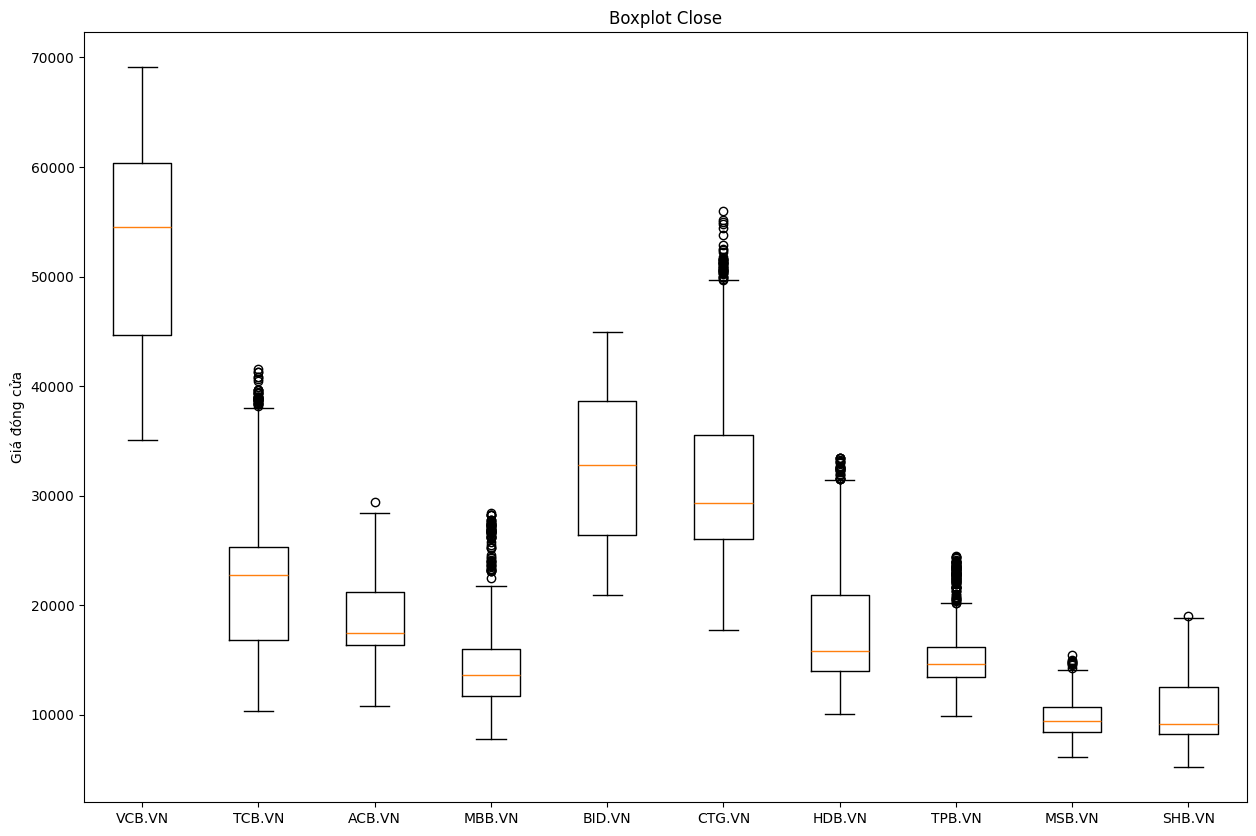

In [7]:
# Vẽ boxplot cho tất cả ngân hàng VN
plt.figure(figsize=(15, 10))
plt.boxplot([data[data['Ngan_hang_VN'] == ticker]['Close'] for ticker in ngan_hang_vn], labels=ngan_hang_vn)
plt.title('Boxplot Close')
plt.ylabel('Giá đóng cửa')
plt.show()

# Handling Outliers

In [8]:
# Xử lý outliers bằng tứ phân vị
def handle_outliers(data, column, lower_quantile=0.05, upper_quantile=0.95):
    """
    Xử lý outliers trong một cột của DataFrame sử dụng phương pháp tứ phân vị (quantile).

    Args:
        data (pd.DataFrame): DataFrame chứa dữ liệu.
        column (str): Tên cột cần xử lý outliers.
        lower_quantile (float): Ngưỡng tứ phân vị dưới (mặc định 0.05).
        upper_quantile (float): Ngưỡng tứ phân vị trên (mặc định 0.95).

    Returns:
        pd.DataFrame: DataFrame mới với outliers được thay thế bằng giá trị biên.
    """
    Q1 = data[column].quantile(lower_quantile)
    Q3 = data[column].quantile(upper_quantile)
    # IQR = Q3 - Q1

    # Xác định giới hạn dưới và trên
    # lower_bound = Q1 - 1.5 * IQR
    # upper_bound = Q3 + 1.5 * IQR
    lower_bound = Q1
    upper_bound = Q3

    # Thay thế outliers bằng giá trị biên
    data_cleaned = data.copy()
    data_cleaned[column] = np.where(data_cleaned[column] < lower_bound, lower_bound, data_cleaned[column])
    data_cleaned[column] = np.where(data_cleaned[column] > upper_bound, upper_bound, data_cleaned[column])

    return data_cleaned

In [9]:
data = handle_outliers(data, 'Close')

# Apply Regression to Analyze

In [10]:
# Apply Regression to Analyze
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Chọn các feature (X) và target (y)
# Sử dụng các cột 'Open', 'High', 'Low', 'Volume' để dự đoán 'Close'
features = ['Open', 'High', 'Low', 'Volume']
target = 'Close'

# Đảm bảo các cột cần thiết có trong DataFrame
if all(col in data.columns for col in features + [target]):
    X = data[features]
    y = data[target]

    # Chia dữ liệu thành tập huấn luyện và tập kiểm tra
    # Sử dụng train_test_split với test_size = 20%
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Khởi tạo và huấn luyện mô hình Hồi quy Tuyến tính
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Dự đoán trên tập kiểm tra
    y_pred = model.predict(X_test)

    # Đánh giá mô hình
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("--- KẾT QUẢ HỒI QUY TUYẾN TÍNH ---")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"R-squared (R2): {r2:.2f}")

    # Hiển thị các hệ số của mô hình
    print("\nHệ số hồi quy:")
    for feature, coef in zip(features, model.coef_):
        print(f"{feature}: {coef:.4f}")
    print(f"Intercept: {model.intercept_:.4f}")

else:
    print("Không đủ các cột cần thiết ('Open', 'High', 'Low', 'Volume', 'Close') trong DataFrame.")

--- KẾT QUẢ HỒI QUY TUYẾN TÍNH ---
Mean Squared Error (MSE): 1248415.87
R-squared (R2): 0.99

Hệ số hồi quy:
Open: -0.4215
High: 1.1996
Low: 0.1500
Volume: -0.0000
Intercept: 1196.8352


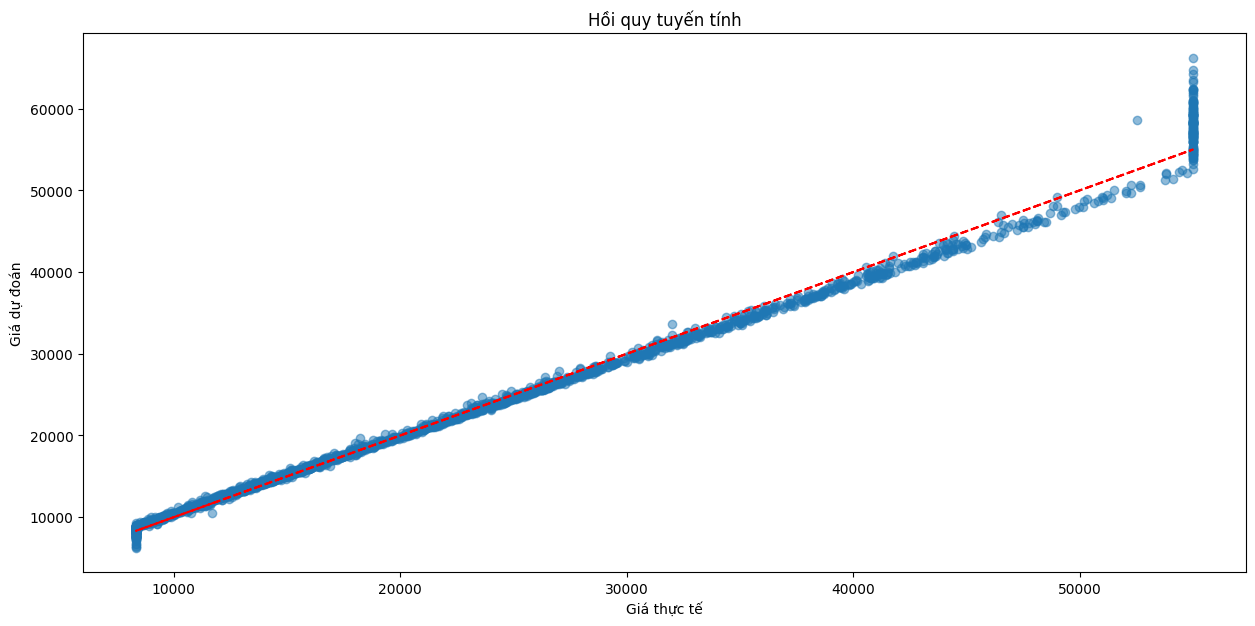

In [11]:
# Vẽ đường hồi quy
plt.figure(figsize=(15, 7))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot(y_test, y_test, color='red', linestyle='--')
plt.xlabel('Giá thực tế')
plt.ylabel('Giá dự đoán')
plt.title('Hồi quy tuyến tính')
plt.show()

In [12]:
# ĐỀ XUẤT THAY THẾ CHO Ô 15 (Cách 1: Time-Series)
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Xử lý lại dữ liệu (chạy trên từng mã)
data_cleaned = data # Lấy dữ liệu đã làm sạch từ ô 13

# Tạo DataFrame mới để hồi quy
regression_results = {}

for ticker in data_cleaned['Ngan_hang_VN'].unique():
    df_ticker = data_cleaned[data_cleaned['Ngan_hang_VN'] == ticker].copy()

    # 1. Tạo Log Returns (như trong bài giảng Week 4)
    df_ticker['log_return'] = np.log(df_ticker['Close'] / df_ticker['Close'].shift(1))

    # 2. Tạo biến mục tiêu (y): Lợi nhuận của ngày mai (dịch chuyển -1)
    df_ticker['target_y'] = df_ticker['log_return'].shift(-1)

    # 3. Tạo biến độc lập (X): Lợi nhuận và khối lượng hôm nay
    df_ticker['feature_x1_return'] = df_ticker['log_return']
    df_ticker['feature_x2_volume'] = df_ticker['Volume']

    df_ticker = df_ticker.dropna()

    if df_ticker.empty:
        continue

    features = ['feature_x1_return', 'feature_x2_volume']
    target = 'target_y'

    X = df_ticker[features]
    y = df_ticker[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False) # Không xáo trộn dữ liệu chuỗi thời gian

    if X_train.empty:
        continue

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Đánh giá mô hình
    r2 = r2_score(y_test, y_pred)
    print(f"--- KẾT QUẢ HỒI QUY DỰ ĐOÁN ({ticker}) ---")
    print(f"R-squared (R2): {r2:.4f}") # Kết quả R2 sẽ thấp, điều này BÌNH THƯỜNG trong tài chính [cite: 1503]

--- KẾT QUẢ HỒI QUY DỰ ĐOÁN (ACB.VN) ---
R-squared (R2): 0.0077
--- KẾT QUẢ HỒI QUY DỰ ĐOÁN (BID.VN) ---
R-squared (R2): -0.0258
--- KẾT QUẢ HỒI QUY DỰ ĐOÁN (CTG.VN) ---
R-squared (R2): -0.0168
--- KẾT QUẢ HỒI QUY DỰ ĐOÁN (HDB.VN) ---
R-squared (R2): -0.0083
--- KẾT QUẢ HỒI QUY DỰ ĐOÁN (MBB.VN) ---
R-squared (R2): -0.0028
--- KẾT QUẢ HỒI QUY DỰ ĐOÁN (MSB.VN) ---
R-squared (R2): -0.0028
--- KẾT QUẢ HỒI QUY DỰ ĐOÁN (SHB.VN) ---
R-squared (R2): -0.0207
--- KẾT QUẢ HỒI QUY DỰ ĐOÁN (TCB.VN) ---
R-squared (R2): -0.0027
--- KẾT QUẢ HỒI QUY DỰ ĐOÁN (TPB.VN) ---
R-squared (R2): 0.0018
--- KẾT QUẢ HỒI QUY DỰ ĐOÁN (VCB.VN) ---
R-squared (R2): -0.0710


In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Lấy dữ liệu đã được làm sạch outliers từ ô 13
data_cleaned = data

print("--- KẾT QUẢ HỒI QUY DỰ ĐOÁN LỢI NHUẬN NGÀY MAI ---")

for ticker in data_cleaned['Ngan_hang_VN'].unique():
    df_ticker = data_cleaned[data_cleaned['Ngan_hang_VN'] == ticker].copy()

    # 1. Tính Log Returns (như trong bài giảng) [cite: 785]
    df_ticker['log_return'] = np.log(df_ticker['Close'] / df_ticker['Close'].shift(1))

    # 2. Tạo biến mục tiêu (y): Lợi nhuận của ngày mai (dịch chuyển -1)
    df_ticker['target_y'] = df_ticker['log_return'].shift(-1)

    # 3. Tạo biến độc lập (X): Lợi nhuận và khối lượng hôm nay
    df_ticker['feature_x_return'] = df_ticker['log_return']
    df_ticker['feature_x_volume'] = df_ticker['Volume']

    # 4. Xóa các dòng NaN phát sinh do shift()
    df_ticker = df_ticker.dropna()

    if df_ticker.empty:
        continue

    features = ['feature_x_return', 'feature_x_volume']
    target = 'target_y'

    X = df_ticker[features]
    y = df_ticker[target]

    # Chia dữ liệu, không xáo trộn (shuffle=False) vì đây là chuỗi thời gian
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

    if X_train.empty or X_test.empty:
        continue

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Đánh giá mô hình
    r2 = r2_score(y_test, y_pred)
    print(f"\nTicker: {ticker}")
    print(f"R-squared (R2): {r2:.4f}")
    print(f"Hệ số (Lợi nhuận): {model.coef_[0]:.4f}, (Khối lượng): {model.coef_[1]:.4e}")

--- KẾT QUẢ HỒI QUY DỰ ĐOÁN LỢI NHUẬN NGÀY MAI ---

Ticker: ACB.VN
R-squared (R2): 0.0077
Hệ số (Lợi nhuận): 0.0043, (Khối lượng): -4.4694e-11

Ticker: BID.VN
R-squared (R2): -0.0258
Hệ số (Lợi nhuận): -0.0486, (Khối lượng): 4.5127e-10

Ticker: CTG.VN
R-squared (R2): -0.0168
Hệ số (Lợi nhuận): -0.0355, (Khối lượng): 1.0027e-10

Ticker: HDB.VN
R-squared (R2): -0.0083
Hệ số (Lợi nhuận): -0.0223, (Khối lượng): 1.7332e-10

Ticker: MBB.VN
R-squared (R2): -0.0028
Hệ số (Lợi nhuận): 0.0068, (Khối lượng): 3.6685e-11

Ticker: MSB.VN
R-squared (R2): -0.0028
Hệ số (Lợi nhuận): 0.0261, (Khối lượng): 4.6868e-11

Ticker: SHB.VN
R-squared (R2): -0.0207
Hệ số (Lợi nhuận): 0.1549, (Khối lượng): 1.9525e-11

Ticker: TCB.VN
R-squared (R2): -0.0027
Hệ số (Lợi nhuận): 0.0828, (Khối lượng): 2.0140e-11

Ticker: TPB.VN
R-squared (R2): 0.0018
Hệ số (Lợi nhuận): -0.0546, (Khối lượng): -4.9467e-12

Ticker: VCB.VN
R-squared (R2): -0.0710
Hệ số (Lợi nhuận): 0.0197, (Khối lượng): -1.5940e-10


In [14]:
import statsmodels.api as sm

# Lấy dữ liệu đã được làm sạch outliers từ ô 13
data_cleaned = data

# 1. Tính log returns cho tất cả các mã
# (Chúng ta cần tính toán lại sau khi làm sạch outliers ở ô 13)
data_cleaned['log_return'] = data_cleaned.groupby('Ngan_hang_VN')['Close'].transform(lambda x: np.log(x / x.shift(1)))
data_cleaned = data_cleaned.dropna()

# 2. Tạo bảng pivot để các mã nằm trên các cột riêng biệt
try:
    df_pivot = data_cleaned.pivot(columns='Ngan_hang_VN', values='log_return')
    df_pivot = df_pivot.dropna() # Đảm bảo không có ngày nào thiếu dữ liệu

    # 3. Chọn y (biến phụ thuộc) và X (biến độc lập)
    # Ví dụ: Hồi quy lợi nhuận VCB (y) theo TCB (X)
    y = df_pivot['VCB.VN']
    X = df_pivot['TCB.VN']

    # Thêm hằng số (intercept - Beta 0) [cite: 799]
    X = sm.add_constant(X)

    # 4. Chạy mô hình OLS (Ordinary Least Squares)
    model = sm.OLS(y, X).fit()

    print("--- KẾT QUẢ HỒI QUY CHÉO (Lợi nhuận VCB.VN vs TCB.VN) ---")
    print(model.summary())

except KeyError as e:
    print(f"Lỗi: Không tìm thấy mã cổ phiếu {e}. Hãy đảm bảo VCB.VN và TCB.VN có trong dữ liệu.")
except Exception as e:
    print(f"Đã xảy ra lỗi: {e}")

--- KẾT QUẢ HỒI QUY CHÉO (Lợi nhuận VCB.VN vs TCB.VN) ---
                            OLS Regression Results                            
Dep. Variable:                 VCB.VN   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     211.5
Date:                Fri, 14 Nov 2025   Prob (F-statistic):           2.96e-44
Time:                        07:20:22   Log-Likelihood:                 3637.0
No. Observations:                1205   AIC:                            -7270.
Df Residuals:                    1203   BIC:                            -7260.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------